# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
geneal_population = pd.read_csv('./Udacity_AZDIAS_Subset.csv', delimiter=';')
# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(f'geneal_population shape : {geneal_population.shape}')

print("geneal_population data sample :")
geneal_population.head()


geneal_population shape : (891221, 85)
geneal_population data sample :


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
print(f'geneal_population shape : {feat_info.shape}')

print("geneal_population data sample :")
feat_info.head()


geneal_population shape : (85, 4)
geneal_population data sample :


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.

#TODO make sure the list that have [''] need to be []
def parse_missing_as_strings(slice: str):
    return list(map(lambda value: int(value, base=10) if value.lstrip('-').isnumeric() else value ,slice.strip('[]').split(',')))

attributes = feat_info['attribute']
parsed_missing_values = feat_info['missing_or_unknown'].apply(parse_missing_as_strings)

assert len(attributes) == len(parsed_missing_values)


for attribute, missing_values in zip(attributes, parsed_missing_values):
    geneal_population[attribute].replace(to_replace=missing_values, value=np.NaN, inplace=True)
    
    print(attribute, missing_values)

AGER_TYP [-1, 0]
ALTERSKATEGORIE_GROB [-1, 0, 9]
ANREDE_KZ [-1, 0]
CJT_GESAMTTYP [0]
FINANZ_MINIMALIST [-1]
FINANZ_SPARER [-1]
FINANZ_VORSORGER [-1]
FINANZ_ANLEGER [-1]
FINANZ_UNAUFFAELLIGER [-1]
FINANZ_HAUSBAUER [-1]
FINANZTYP [-1]
GEBURTSJAHR [0]
GFK_URLAUBERTYP ['']
GREEN_AVANTGARDE ['']
HEALTH_TYP [-1, 0]
LP_LEBENSPHASE_FEIN [0]
LP_LEBENSPHASE_GROB [0]
LP_FAMILIE_FEIN [0]
LP_FAMILIE_GROB [0]
LP_STATUS_FEIN [0]
LP_STATUS_GROB [0]
NATIONALITAET_KZ [-1, 0]
PRAEGENDE_JUGENDJAHRE [-1, 0]
RETOURTYP_BK_S [0]
SEMIO_SOZ [-1, 9]
SEMIO_FAM [-1, 9]
SEMIO_REL [-1, 9]
SEMIO_MAT [-1, 9]
SEMIO_VERT [-1, 9]
SEMIO_LUST [-1, 9]
SEMIO_ERL [-1, 9]
SEMIO_KULT [-1, 9]
SEMIO_RAT [-1, 9]
SEMIO_KRIT [-1, 9]
SEMIO_DOM [-1, 9]
SEMIO_KAEM [-1, 9]
SEMIO_PFLICHT [-1, 9]
SEMIO_TRADV [-1, 9]
SHOPPER_TYP [-1]
SOHO_KZ [-1]
TITEL_KZ [-1, 0]
VERS_TYP [-1]
ZABEOTYP [-1, 9]
ALTER_HH [0]
ANZ_PERSONEN ['']
ANZ_TITEL ['']
HH_EINKOMMEN_SCORE [-1, 0]
KK_KUNDENTYP [-1]
W_KEIT_KIND_HH [-1, 0]
WOHNDAUER_2008 [-1, 0]
ANZ_HAUSHAL

In [6]:
0 in geneal_population['LP_LEBENSPHASE_FEIN'].unique(), 'XX' in geneal_population['CAMEO_INTL_2015'].unique()

(False, False)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

nan_counts = geneal_population.isna().sum()
nan_counts_sorted = nan_counts.sort_values(ascending=False)

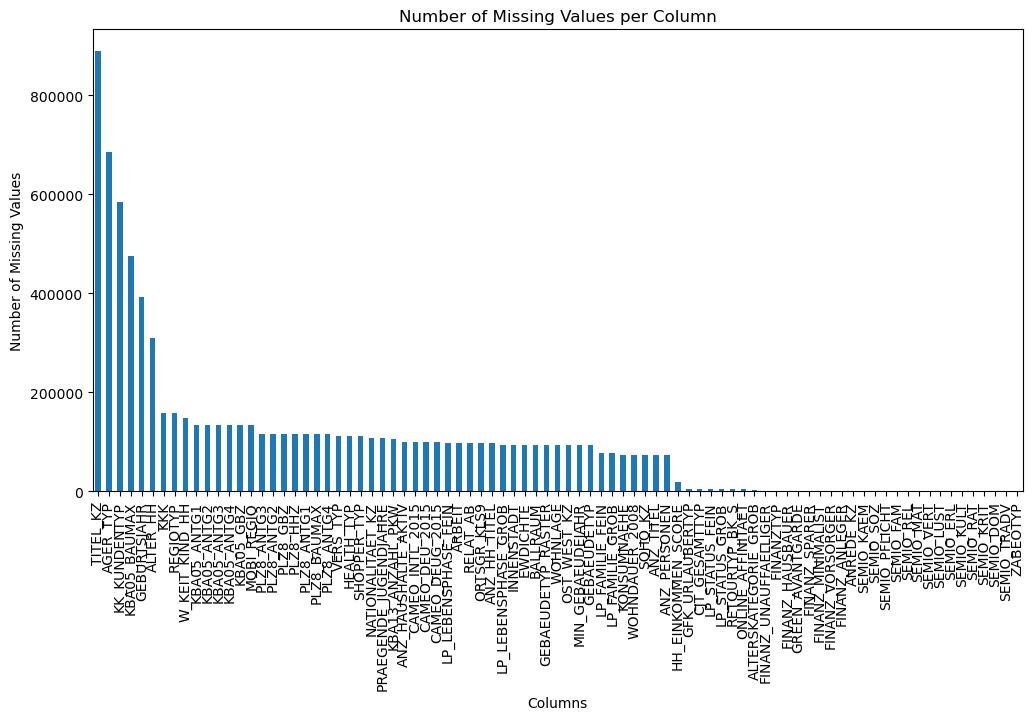

In [8]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(12, 6))
nan_counts_sorted.plot(kind='bar')
plt.title('Number of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.show()

In [9]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

threshold = 0.3 * len(geneal_population)

outlier_columns = nan_counts[nan_counts > threshold].index

geneal_population_encoded = geneal_population.drop(columns=outlier_columns)

print(f"Removed columns: {list(outlier_columns)}")

print(f"Shape of the cleaned dataset: {geneal_population_encoded.shape}")


Removed columns: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
Shape of the cleaned dataset: (891221, 79)


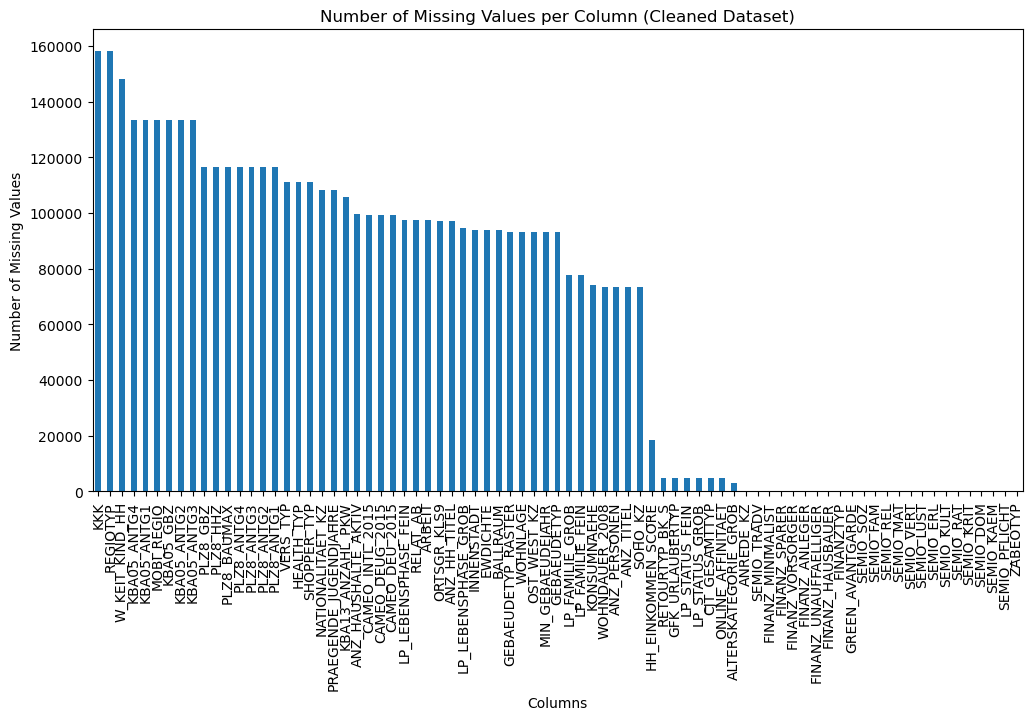

In [10]:
nan_counts_cleaned = geneal_population_encoded.isna().sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
nan_counts_cleaned.plot(kind='bar')
plt.title('Number of Missing Values per Column (Cleaned Dataset)')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.show()

#### Discussion 1.1.2: Assess Missing Data in Each Column

Looking at the data there is somewhat of a pattern of missing values, you could see a chunk of 2-8 columns that have about the same number of undefined numbers, then the next chunk, and so forth until it reaches a point where the there are columns that have no missing data at all.


The columns I removed are :
- AGER_TYP
- TITEL_KZ
- KK_KUNDENTYP
- KBA05_BAUMAX

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

0    49
1     4
2     4
3     9
4     3
dtype: int64


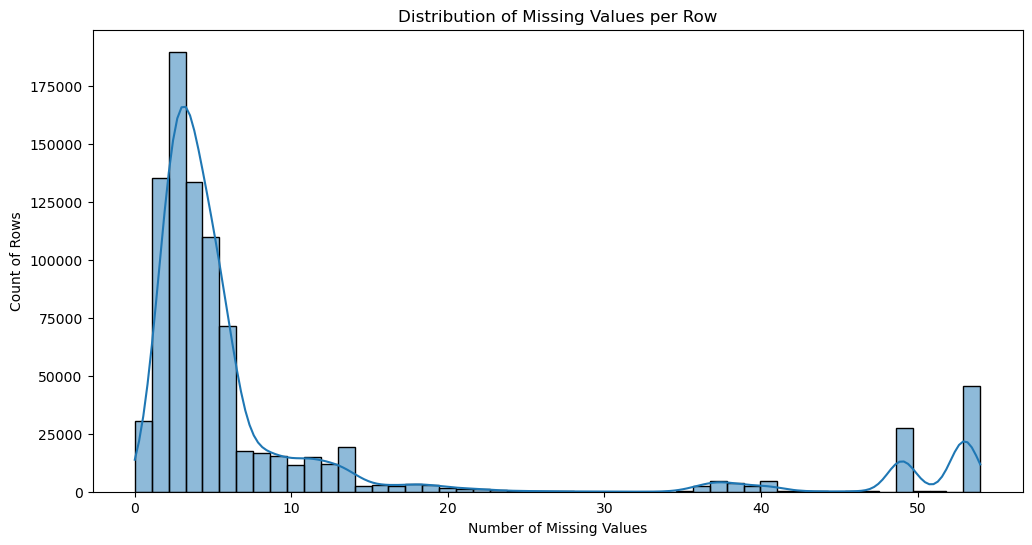

In [11]:
# How much data is missing in each row of the dataset?

nan_counts_per_row = geneal_population.isna().sum(axis=1)
print(nan_counts_per_row.head())

plt.figure(figsize=(12, 6))
sns.histplot(nan_counts_per_row, kde=True, bins=50)
plt.title('Distribution of Missing Values per Row')
plt.xlabel('Number of Missing Values')
plt.ylabel('Count of Rows')
plt.show()

In [12]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#threshold = nan_counts_per_row.median()
threshold = 30

subset_below_threshold = geneal_population[nan_counts_per_row <= threshold]
subset_above_threshold = geneal_population[nan_counts_per_row > threshold]

print(f"Shape of subset below threshold: {subset_below_threshold.shape}")
print(f"Shape of subset above threshold: {subset_above_threshold.shape}")

Shape of subset below threshold: (797981, 85)
Shape of subset above threshold: (93240, 85)


In [13]:
def compare_distributions(column):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    sns.countplot(x=column, data=subset_above_threshold, ax=axes[0])
    axes[0].set_title(f'{column} - Above Threshold')
    
    sns.countplot(x=column, data=subset_below_threshold, ax=axes[1])
    axes[1].set_title(f'{column} - Below Threshold')
    
    plt.tight_layout()
    plt.show()

In [14]:
threshold_percentage = 0.005
threshold = threshold_percentage * len(geneal_population)

columns_with_few_missing = nan_counts[nan_counts <= threshold].index

selected_columns = columns_with_few_missing[:5]

print(f"Selected columns: {list(selected_columns)}")

Selected columns: ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER']


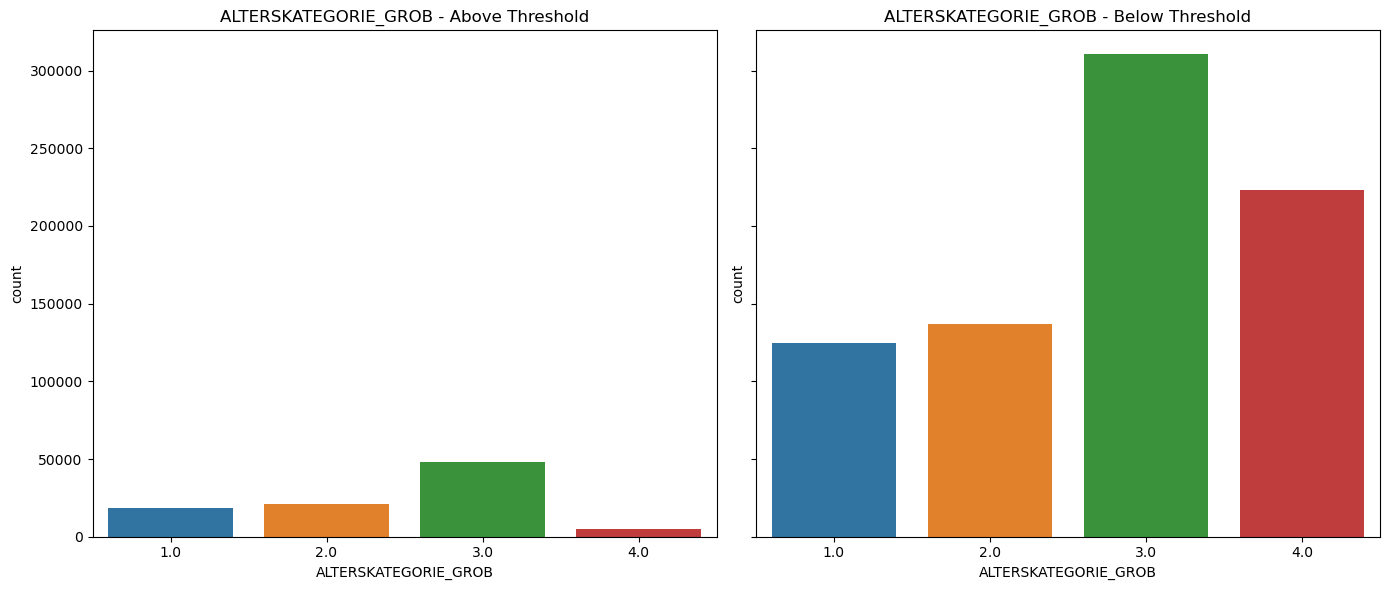

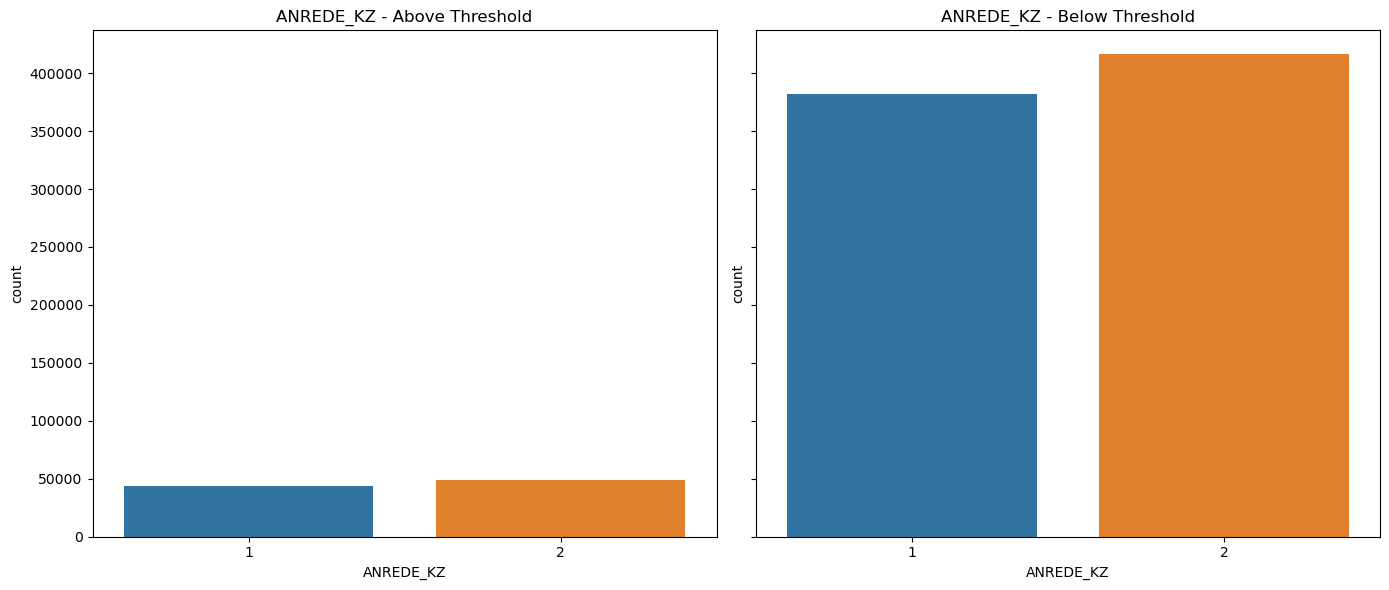

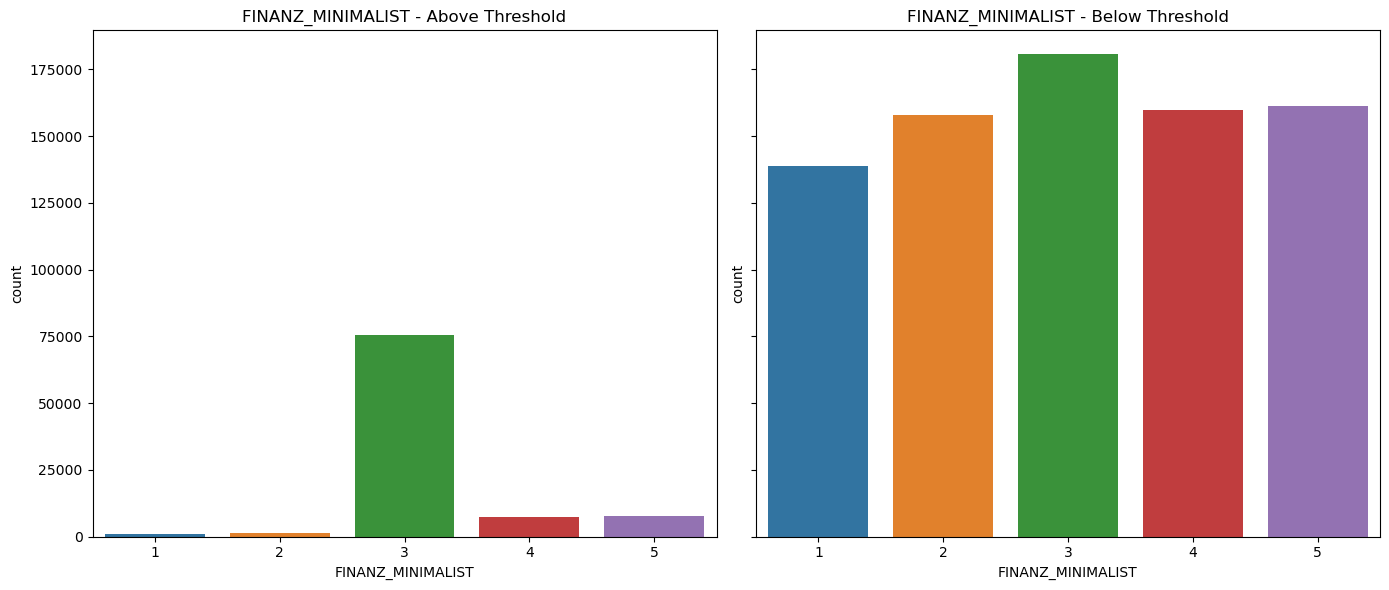

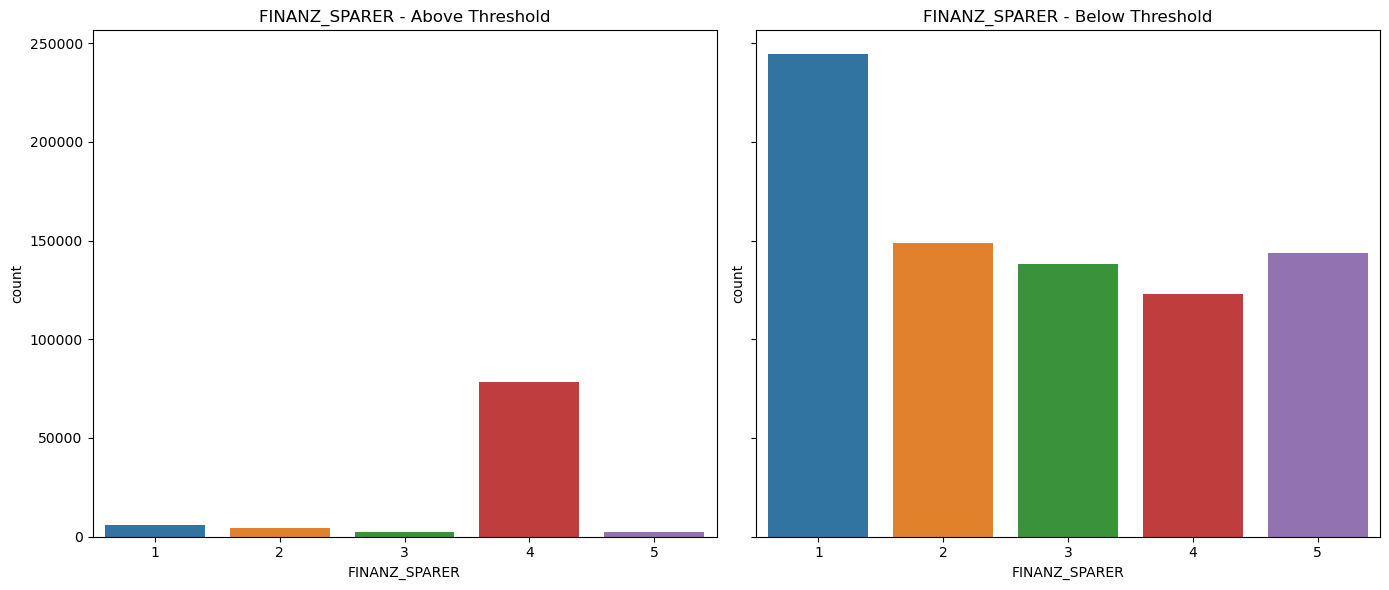

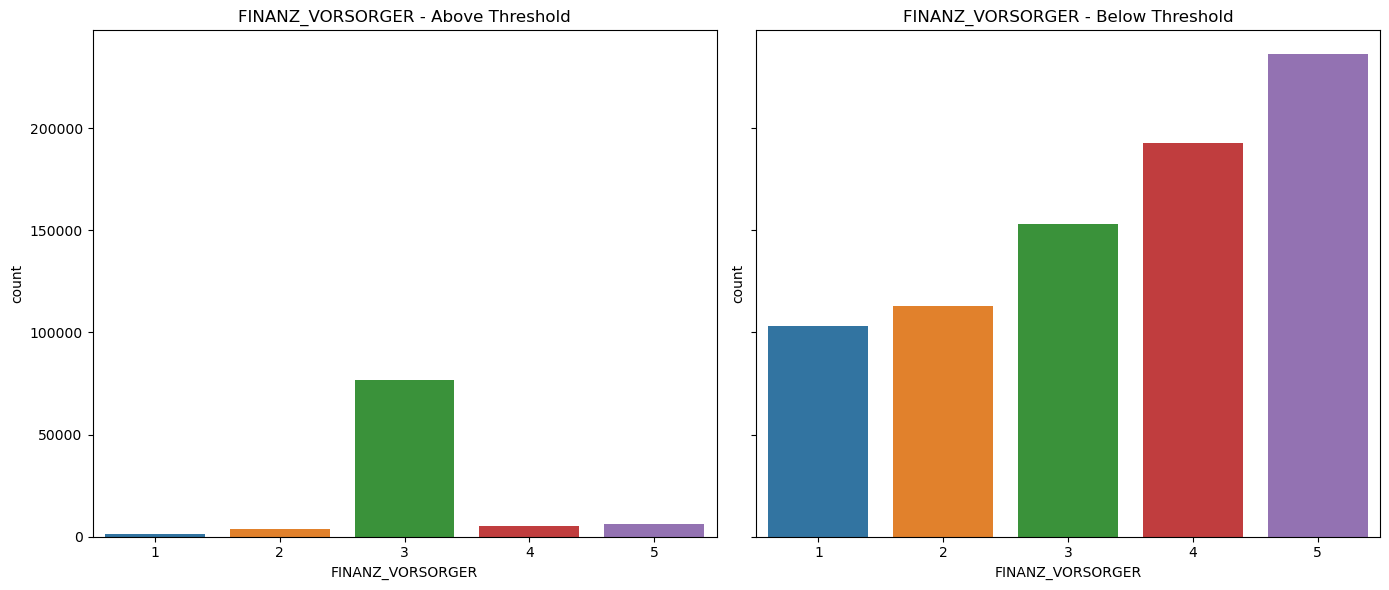

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

selected_columns = list(selected_columns)
for col in selected_columns:
    compare_distributions(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Looking at the data below the threshold I defense there are a lot of nan values that are distributed around. Still, when we look at the data above the threshold we see that the data is more concentrated and uniform.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [16]:
# How many features are there of each data type?

print(feat_info['type'].unique()) 
print(f"the number of different types are {feat_info['type'].unique().shape[0]}")

['categorical' 'ordinal' 'numeric' 'mixed' 'interval']
the number of different types are 5


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [17]:
categorical_columns = list(feat_info.loc[feat_info['type'] == 'categorical']['attribute'])
ordinal_columns = list(feat_info.loc[feat_info['type'] == 'ordinal']['attribute'])
mixed_columns = list(feat_info.loc[feat_info['type'] == 'mixed']['attribute'])
numeric_columns = list(feat_info.loc[feat_info['type'] == 'numeric']['attribute'])
interval_columns = list(feat_info.loc[feat_info['type'] == 'interval']['attribute'])

In [18]:
all_values = []
for attribute in ordinal_columns:
    all_values.extend(geneal_population[attribute].unique())

unique_values = np.unique(np.array(all_values))

print(unique_values)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]


In [19]:
all_values = []

for attribute in categorical_columns:
    print(attribute, geneal_population[attribute].unique())


# for attribute in feat_info.loc[feat_info['type'] == 'categorical']['attribute']:
#     all_values.extend(geneal_population[attribute].unique())

# unique_values = np.unique(np.array(all_values))

# print(unique_values, unique_values.shape)

AGER_TYP [nan  2.  3.  1.]
ANREDE_KZ [1 2]
CJT_GESAMTTYP [ 2.  5.  3.  4.  1.  6. nan]
FINANZTYP [4 1 6 5 2 3]
GFK_URLAUBERTYP [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]
GREEN_AVANTGARDE [0 1]
LP_FAMILIE_FEIN [ 2.  5.  1. nan 10.  7. 11.  3.  8.  4.  6.  9.]
LP_FAMILIE_GROB [ 2.  3.  1. nan  5.  4.]
LP_STATUS_FEIN [ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]
LP_STATUS_GROB [ 1.  2.  4.  5.  3. nan]
NATIONALITAET_KZ [nan  1.  3.  2.]
SHOPPER_TYP [nan  3.  2.  1.  0.]
SOHO_KZ [nan  1.  0.]
TITEL_KZ [nan  4.  1.  3.  5.  2.]
VERS_TYP [nan  2.  1.]
ZABEOTYP [3 5 4 1 6 2]
KK_KUNDENTYP [nan  1.  3.  6.  4.  2.  5.]
GEBAEUDETYP [nan  8.  1.  3.  2.  6.  4.  5.]
OST_WEST_KZ [nan 'W' 'O']
CAMEO_DEUG_2015 [nan '8' '4' '2' '6' '1' '9' '5' '7' '3']
CAMEO_DEU_2015 [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C

In [20]:
#for attribute in feat_info.loc[feat_info['type'] == 'numeric']['attribute']:
#    print(geneal_population[attribute].unique())

all_values = []

for attribute in numeric_columns:
    all_values.extend(geneal_population[attribute].unique())

unique_values = np.unique(np.array(all_values))

print(unique_values)
unique_values.max(), unique_values.min(), unique_values.mean(), unique_values.std()

[0.0e+00 1.0e+00 2.0e+00 ... 2.2e+03 2.3e+03     nan]


(nan, nan, nan, nan)

In [21]:
for attribute in mixed_columns:
    print(geneal_population[attribute].unique(), attribute)

#all_values = []
#for attribute in feat_info.loc[feat_info['type'] == 'mixed']['attribute']:
#    all_values.extend(geneal_population[attribute].unique())

#unique_values = np.unique(np.array(all_values))
#print(unique_values, unique_values.shape)

[15. 21.  3. nan 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 11. 25. 13.
  7. 18. 31. 19. 38. 35. 30. 22. 14. 33. 29. 24. 28. 37. 26. 39. 27. 36.
  9. 34. 40. 16. 17.] LP_LEBENSPHASE_FEIN
[ 4.  6.  1. nan 10.  2.  3.  5.  7. 12. 11.  9.  8.] LP_LEBENSPHASE_GROB
[nan 14. 15.  8.  3. 10. 11.  5.  9.  6.  4.  2.  1. 12. 13.  7.] PRAEGENDE_JUGENDJAHRE
[nan  4.  2.  7.  3.  5.  1.  8.  0.] WOHNLAGE
[nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32'] CAMEO_INTL_2015
[nan  5.  1.  2.  3.  4.] KBA05_BAUMAX
[nan  1.  2.  4.  5.  3.] PLZ8_BAUMAX


In [22]:
all_values = []
for attribute in interval_columns:
    all_values.extend(geneal_population[attribute].unique())

unique_values = np.unique(np.array(all_values))
print(unique_values)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. nan]


In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# I did that in the cells above

# There is the OST_WEST_KZ column that is binary looking at the data dictionary it only could be W or O so we could encode it as 0 and 1
# i will drop the column CAMEO_DEUG_2015
# Column CAMEO_DEU_2015 a multi-level categorical variable in the "categorical" type while the reset could be numeric so i will leave them as they are
# Column CAMEO_INTL_2015 is a multi-level categorical variable in the "Mixed" type while the reset could be numeric so i will leave them as they are

In [24]:
# Re-encode categorical variable(s) to be kept in the analysis.

binary_non_numeric_var = 'OST_WEST_KZ'  # Based on the provided context in the dictionary
geneal_population[binary_non_numeric_var] = geneal_population[binary_non_numeric_var].map({'W': 1, 'O': 0})

multi_level_categorical_vars = ['CAMEO_DEU_2015']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(geneal_population[multi_level_categorical_vars])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(multi_level_categorical_vars))

geneal_population_encoded = geneal_population.drop(columns=multi_level_categorical_vars).reset_index(drop=True)
geneal_population_encoded = pd.concat([geneal_population_encoded, encoded_df], axis=1)

print("Columns encoded.")
geneal_population_encoded.head()

/home/asakhel/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Columns encoded.


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_nan
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,1.0,4.0,8,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,1.0,2.0,4,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,1.0,7.0,2,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,1.0,3.0,6,43,1.0,4.0

#### Discussion 1.2.1: Re-Encode Categorical Features

Out of all the categorical features I decided to drop CAMEO_DEUG_2015  since I think that this is the only categorical feature to sacrifice.
But looking at the categorical features most of them could work as numeric values except 3 which are 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', and 'PRAEGENDE_JUGENDJAHRE'.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [25]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

decade_mapping = {
    -1: 'Unknown', 0: 'Unknown',
    1: '40s', 2: '40s', 3: '50s', 4: '50s',
    5: '60s', 6: '60s', 7: '60s', 8: '70s',
    9: '70s', 10: '80s', 11: '80s', 12: '80s',
    13: '80s', 14: '90s', 15: '90s'
}


movement_type_mapping = {
    -1: 'Unknown', 0: 'Unknown',
    1: 'Mainstream', 2: 'Avantgarde', 3: 'Mainstream', 4: 'Avantgarde',
    5: 'Mainstream', 6: 'Avantgarde', 7: 'Avantgarde', 8: 'Mainstream',
    9: 'Avantgarde', 10: 'Mainstream', 11: 'Avantgarde', 12: 'Mainstream',
    13: 'Avantgarde', 14: 'Mainstream', 15: 'Avantgarde'
}

geneal_population_encoded['Decade'] = geneal_population_encoded['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)
geneal_population_encoded['Movement_Type'] = geneal_population_encoded['PRAEGENDE_JUGENDJAHRE'].map(movement_type_mapping)

print(geneal_population_encoded[['PRAEGENDE_JUGENDJAHRE', 'Decade', 'Movement_Type']].head())

   PRAEGENDE_JUGENDJAHRE Decade Movement_Type
0                    NaN    NaN           NaN
1                   14.0    90s    Mainstream
2                   15.0    90s    Avantgarde
3                    8.0    70s    Mainstream
4                    8.0    70s    Mainstream


In [26]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

wealth_level_mapping = {
    '-1': 'Unknown', 'XX': 'Unknown',
    '11': 'Wealthy', '12': 'Wealthy', '13': 'Wealthy', '14': 'Wealthy', '15': 'Wealthy',
    '21': 'Prosperous', '22': 'Prosperous', '23': 'Prosperous', '24': 'Prosperous', '25': 'Prosperous',
    '31': 'Comfortable', '32': 'Comfortable', '33': 'Comfortable', '34': 'Comfortable', '35': 'Comfortable',
    '41': 'Less Affluent', '42': 'Less Affluent', '43': 'Less Affluent', '44': 'Less Affluent', '45': 'Less Affluent',
    '51': 'Poorer', '52': 'Poorer', '53': 'Poorer', '54': 'Poorer', '55': 'Poorer'
}

life_stage_mapping = {
    '-1': 'Unknown', 'XX': 'Unknown',
    '11': 'Pre-Family', '12': 'Young Couples With Children', '13': 'Families With School Age Children', '14': 'Older Families & Mature Couples', '15': 'Elders In Retirement',
    '21': 'Pre-Family', '22': 'Young Couples With Children', '23': 'Families With School Age Children', '24': 'Older Families & Mature Couples', '25': 'Elders In Retirement',
    '31': 'Pre-Family', '32': 'Young Couples With Children', '33': 'Families With School Age Children', '34': 'Older Families & Mature Couples', '35': 'Elders In Retirement',
    '41': 'Pre-Family', '42': 'Young Couples With Children', '43': 'Families With School Age Children', '44': 'Older Families & Mature Couples', '45': 'Elders In Retirement',
    '51': 'Pre-Family', '52': 'Young Couples With Children', '53': 'Families With School Age Children', '54': 'Older Families & Mature Couples', '55': 'Elders In Retirement'
}


geneal_population_encoded['Wealth_Level'] = geneal_population_encoded['CAMEO_INTL_2015'].map(wealth_level_mapping)
geneal_population_encoded['Life_Stage'] = geneal_population_encoded['CAMEO_INTL_2015'].map(life_stage_mapping)

# Display the first few rows to verify the new variables
print(geneal_population_encoded[['CAMEO_INTL_2015', 'Wealth_Level', 'Life_Stage']].head())

  CAMEO_INTL_2015   Wealth_Level                         Life_Stage
0             NaN            NaN                                NaN
1              51         Poorer                         Pre-Family
2              24     Prosperous    Older Families & Mature Couples
3              12        Wealthy        Young Couples With Children
4              43  Less Affluent  Families With School Age Children


#### Discussion 1.2.2: Engineer Mixed-Type Features

The PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 features expanded into 4 new features.

PRAEGENDE_JUGENDJAHRE turn into:-
- Decade
- Movement_Type

CAMEO_INTL_2015 turn into:-
- Wealth_Level
- Life_Stage
But after looking at these new 4 variables I decided to drop out Decade and Movement_Type.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [27]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Drop outlier columns
geneal_population_encoded = geneal_population_encoded.drop(outlier_columns, axis=1)
# Droping CAMEO_DEUG_2015 column
geneal_population_encoded = geneal_population_encoded.drop('CAMEO_DEUG_2015', axis=1)
# Droping CAMEO_INTL_2015 and PRAEGENDE_JUGENDJAHRE since they are separted into two varible each
geneal_population_encoded = geneal_population_encoded.drop('CAMEO_INTL_2015', axis=1)
geneal_population_encoded = geneal_population_encoded.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

geneal_population_encoded.shape

(891221, 124)

In [28]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#spread numeric_columns, ordinal_columns, interval_columns into list_of_numeric_columns

#There is still 4 columns that are not numeric after engineering CAMEO_INTL_2015 and PRAEGENDE_JUGENDJAHRE
# we have 4 column which are Wealth_Level, Life_Stage, Decade and Movement_Type
# will hot encode Wealth_Level and Life_Stage and drop Decade and Movement_Type

geneal_population_encoded = geneal_population_encoded.drop('Decade', axis=1)
geneal_population_encoded = geneal_population_encoded.drop('Movement_Type', axis=1)

multi_level_categorical_vars = ['Wealth_Level', 'Life_Stage']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(geneal_population_encoded[multi_level_categorical_vars])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(multi_level_categorical_vars))

geneal_population_encoded = geneal_population_encoded.drop(columns=multi_level_categorical_vars).reset_index(drop=True)
geneal_population_encoded = pd.concat([geneal_population_encoded, encoded_df], axis=1)

columns_with_nan_name = ['CAMEO_DEU_2015_nan', 'Wealth_Level_nan', 'Life_Stage_nan']
geneal_population_encoded = geneal_population_encoded.drop(columns=columns_with_nan_name)

geneal_population_encoded.shape

/home/asakhel/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(891221, 129)

In [29]:
geneal_population_encoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Wealth_Level_Comfortable,Wealth_Level_Less Affluent,Wealth_Level_Poorer,Wealth_Level_Prosperous,Wealth_Level_Wealthy,Life_Stage_Elders In Retirement,Life_Stage_Families With School Age Children,Life_Stage_Older Families & Mature Couples,Life_Stage_Pre-Family,Life_Stage_Young Couples With Children
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,1.0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,1.0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,1.0,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [30]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';')
    attributes = feat_info['attribute']
    parsed_missing_values = feat_info['missing_or_unknown'].apply(parse_missing_as_strings)
    
    for attribute, missing_values in zip(attributes, parsed_missing_values):
        df[attribute].replace(to_replace=missing_values, value=np.NaN, inplace=True)
    
    #outlier_columns = nan_counts[nan_counts > threshold].index

    outlier_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    
    geneal_population_encoded = df.drop(columns=outlier_columns)
    geneal_population_encoded = geneal_population_encoded.drop('CAMEO_DEUG_2015', axis=1)
    
    binary_non_numeric_var = 'OST_WEST_KZ'  # Based on the provided context in the dictionary
    geneal_population_encoded[binary_non_numeric_var] = geneal_population_encoded[binary_non_numeric_var].map({'W': 1, 'O': 0})
    
    wealth_level_mapping = {
    '-1': 'Unknown', 'XX': 'Unknown',
    '11': 'Wealthy', '12': 'Wealthy', '13': 'Wealthy', '14': 'Wealthy', '15': 'Wealthy',
    '21': 'Prosperous', '22': 'Prosperous', '23': 'Prosperous', '24': 'Prosperous', '25': 'Prosperous',
    '31': 'Comfortable', '32': 'Comfortable', '33': 'Comfortable', '34': 'Comfortable', '35': 'Comfortable',
    '41': 'Less Affluent', '42': 'Less Affluent', '43': 'Less Affluent', '44': 'Less Affluent', '45': 'Less Affluent',
    '51': 'Poorer', '52': 'Poorer', '53': 'Poorer', '54': 'Poorer', '55': 'Poorer'
    }
    life_stage_mapping = {
        '-1': 'Unknown', 'XX': 'Unknown',
        '11': 'Pre-Family', '12': 'Young Couples With Children', '13': 'Families With School Age Children', '14': 'Older Families & Mature Couples', '15': 'Elders In Retirement',
        '21': 'Pre-Family', '22': 'Young Couples With Children', '23': 'Families With School Age Children', '24': 'Older Families & Mature Couples', '25': 'Elders In Retirement',
        '31': 'Pre-Family', '32': 'Young Couples With Children', '33': 'Families With School Age Children', '34': 'Older Families & Mature Couples', '35': 'Elders In Retirement',
        '41': 'Pre-Family', '42': 'Young Couples With Children', '43': 'Families With School Age Children', '44': 'Older Families & Mature Couples', '45': 'Elders In Retirement',
        '51': 'Pre-Family', '52': 'Young Couples With Children', '53': 'Families With School Age Children', '54': 'Older Families & Mature Couples', '55': 'Elders In Retirement'
    }


    geneal_population_encoded['Wealth_Level'] = geneal_population_encoded['CAMEO_INTL_2015'].map(wealth_level_mapping)
    geneal_population_encoded['Life_Stage'] = geneal_population_encoded['CAMEO_INTL_2015'].map(life_stage_mapping)

    geneal_population_encoded.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    geneal_population_encoded.drop('PRAEGENDE_JUGENDJAHRE',axis=1,  inplace=True)
    
    multi_level_categorical_vars = ['CAMEO_DEU_2015', 'Wealth_Level', 'Life_Stage']
    encoder = OneHotEncoder(sparse=False, handle_unknown='infrequent_if_exist')
    encoded_data = encoder.fit_transform(geneal_population_encoded[multi_level_categorical_vars])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(multi_level_categorical_vars))

    geneal_population_encoded = geneal_population_encoded.drop(columns=multi_level_categorical_vars).reset_index(drop=True)
    geneal_population_encoded = pd.concat([geneal_population_encoded, encoded_df], axis=1)
    
    columns_with_nan_name = ['CAMEO_DEU_2015_nan', 'Wealth_Level_nan', 'Life_Stage_nan']
    geneal_population_encoded = geneal_population_encoded.drop(columns=columns_with_nan_name)
    
    return geneal_population_encoded
    
    

In [31]:
df = pd.read_csv('./Udacity_AZDIAS_Subset.csv', delimiter=';')
encode_df = clean_data(df)
encode_df.shape, df.shape, geneal_population_encoded.shape, encode_df.equals(geneal_population_encoded)

/home/asakhel/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((891221, 129), (891221, 85), (891221, 129), True)

In [32]:
encode_df.columns, geneal_population_encoded.columns
encode_df_set = set(encode_df.columns)
geneal_population_encoded_set = set(geneal_population_encoded.columns)

# Find the unique elements in each list
unique_in_encode_df = encode_df_set - geneal_population_encoded_set
unique_in_geneal_population_encoded = geneal_population_encoded_set - encode_df_set

# Convert sets back to lists if needed
unique_in_encode_df = list(unique_in_encode_df)
unique_in_geneal_population_encoded = list(unique_in_geneal_population_encoded)

# Print the results
print("Unique in encode_df_columns:", unique_in_encode_df)
print("Unique in geneal_population_encoded_columns:", unique_in_geneal_population_encoded)

Unique in encode_df_columns: []
Unique in geneal_population_encoded_columns: []


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [33]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

nan_percentages = geneal_population_encoded.isnull().mean() * 100
print(nan_percentages[nan_percentages > 0].sort_values(ascending=False))

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
imputed_data = imputer.fit_transform(geneal_population_encoded)

# Convert back to DataFrame
geneal_population_encoded = pd.DataFrame(imputed_data, columns=geneal_population_encoded.columns)

KKK                     17.735668
REGIOTYP                17.735668
W_KEIT_KIND_HH          16.605084
KBA05_GBZ               14.959701
KBA05_ANTG4             14.959701
KBA05_ANTG3             14.959701
KBA05_ANTG2             14.959701
KBA05_ANTG1             14.959701
MOBI_REGIO              14.959701
PLZ8_ANTG3              13.073637
PLZ8_ANTG2              13.073637
PLZ8_ANTG1              13.073637
PLZ8_GBZ                13.073637
PLZ8_BAUMAX             13.073637
PLZ8_ANTG4              13.073637
PLZ8_HHZ                13.073637
HEALTH_TYP              12.476816
SHOPPER_TYP             12.476816
VERS_TYP                12.476816
NATIONALITAET_KZ        12.153551
KBA13_ANZAHL_PKW        11.871354
ANZ_HAUSHALTE_AKTIV     11.176913
LP_LEBENSPHASE_FEIN     10.954859
ARBEIT                  10.926022
RELAT_AB                10.926022
ORTSGR_KLS9             10.914689
ANZ_HH_TITEL            10.884842
LP_LEBENSPHASE_GROB     10.611509
BALLRAUM                10.518154
INNENSTADT    

In [34]:
geneal_population_encoded.isnull().sum().sum()

0

In [35]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit and transform the data
scaled_geneal_population = scaler.fit_transform(geneal_population_encoded)

# Convert the scaled data back to a DataFrame
scaled_geneal_population_df = pd.DataFrame(scaled_geneal_population, columns=geneal_population_encoded.columns)



### Discussion 2.1: Apply Feature Scaling

I have successfully implemented feature scaling using StandardScaler from sklearn.preprocessing. The general population demographics data has been scaled to mean 0 and standard deviation 1 for each feature. This scaling was applied using the fit_transform() method, which efficiently fits the scaler to the data and applies the transformation in one step. The scaled data has been converted back to a DataFrame for easy manipulation and analysis. Importantly, I've retained the scaler object, which will be crucial for applying consistent scaling to the customer demographics data later in the project. This approach ensures that all features are on the same scale, which is essential for many machine-learning algorithms and can significantly improve their performance.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [36]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
pca_full = pca.fit_transform(scaled_geneal_population_df)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)


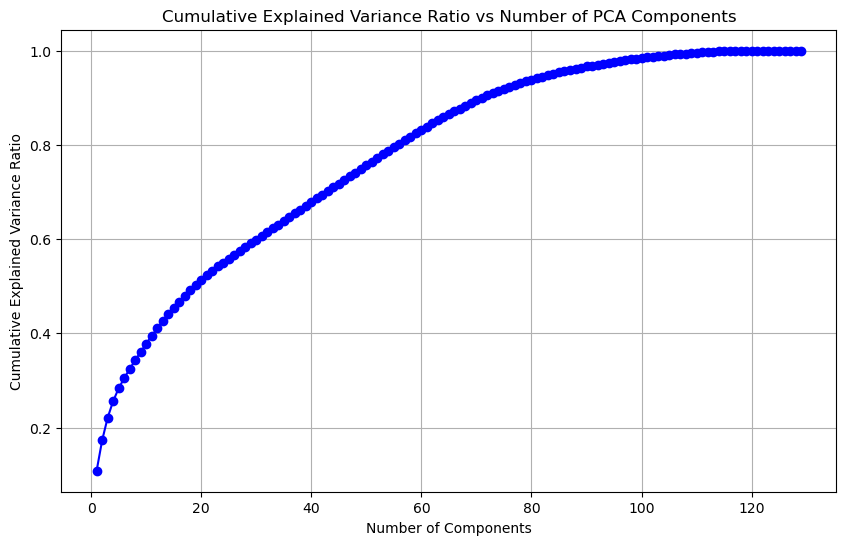

In [37]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs Number of PCA Components')
plt.grid(True)
plt.show()

In [38]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = 65

# Re-fit PCA with chosen number of components
pca_final = PCA(n_components=n_components)
pca_transformed = pca_final.fit_transform(scaled_geneal_population_df)

# Create a DataFrame with the transformed data
pca_df = pd.DataFrame(pca_transformed, columns=[f'PC{i+1}' for i in range(n_components)])

print(f"Total explained variance ratio with {n_components} components: {pca_final.explained_variance_ratio_.sum():.4f}")


Total explained variance ratio with 65 components: 0.8646


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

After looking carefully at the chart I have decided to keep the number of components to 65, this number will reduce the number of the future and have a variance of 86.4%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [39]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def print_pca_component(pca, feature_names, component_number, n_top_features=10):
    component = pca.components_[component_number - 1]
    feature_weights = list(zip(feature_names, component))
    feature_weights.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print(f"Principal Component {component_number}")
    print("Top positive features:")
    for feature, weight in feature_weights[:n_top_features]:
        if weight > 0:
            print(f"{feature}: {weight:.4f}")
    
    print("\nTop negative features:")
    for feature, weight in reversed(feature_weights[-n_top_features:]):
        if weight < 0:
            print(f"{feature}: {weight:.4f}")

# Use the function to print the top features for the first three principal components
print_pca_component(pca_final, scaled_geneal_population_df.columns, 1)

Principal Component 1
Top positive features:
PLZ8_ANTG3: 0.2007
PLZ8_ANTG4: 0.1944
PLZ8_BAUMAX: 0.1848

Top negative features:
CAMEO_DEU_2015_5E: -0.0015
SOHO_KZ: -0.0027
ANZ_TITEL: -0.0035
CAMEO_DEU_2015_5F: -0.0055


In [40]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_pca_component(pca_final, scaled_geneal_population_df.columns, 2)

Principal Component 2
Top positive features:
ALTERSKATEGORIE_GROB: 0.2835
FINANZ_VORSORGER: 0.2549
SEMIO_ERL: 0.2345

Top negative features:
CAMEO_DEU_2015_6A: -0.0009
CAMEO_DEU_2015_9B: -0.0010
SEMIO_VERT: -0.0016
CAMEO_DEU_2015_6B: -0.0028


In [41]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_pca_component(pca_final, scaled_geneal_population_df.columns, 3)

Principal Component 3
Top positive features:
SEMIO_VERT: 0.3460
SEMIO_SOZ: 0.2849
SEMIO_KULT: 0.2745
SEMIO_FAM: 0.2194

Top negative features:
CAMEO_DEU_2015_9E: -0.0006
HEALTH_TYP: -0.0007
CAMEO_DEU_2015_2A: -0.0007
WOHNDAUER_2008: -0.0008
Life_Stage_Families With School Age Children: -0.0011
CAMEO_DEU_2015_5B: -0.0015


### Discussion 2.3: Interpret Principal Components

Principal Component 1: This component seems to be primarily related to housing and building characteristics. The top positive features (PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX) are all associated with building types and sizes in the PLZ8 region. This suggests that PC1 captures variations in housing density and building types across different areas.
Principal Component 2: PC2 appears to be strongly associated with age and financial behavior. The top positive feature ALTERSKATEGORIE_GROB indicates age category, while FINANZ_VORSORGER suggests financial preparedness. SEMIO_ERL (event-oriented) also contributes positively. This component might represent a spectrum from younger, less financially prepared individuals to older, more financially stable ones.
Principal Component 3: This component is dominated by personality and social attitude features. The top positive features (SEMIO_VERT, SEMIO_SOZ, SEMIO_KULT, SEMIO_FAM) all relate to different aspects of personality typology. PC3 seems to capture variations in social engagement, cultural interests, and family orientation among individuals.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [42]:
from sklearn.cluster import KMeans

avg_distances = []
# Over a number of different cluster counts...
for n_clusters in range(1, 31):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pca_df)
    # compute the average within-cluster distances.
    avg_distances.append(-kmeans.score(pca_df))

/home/asakhel/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/asakhel/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/asakhel/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/asakhel/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

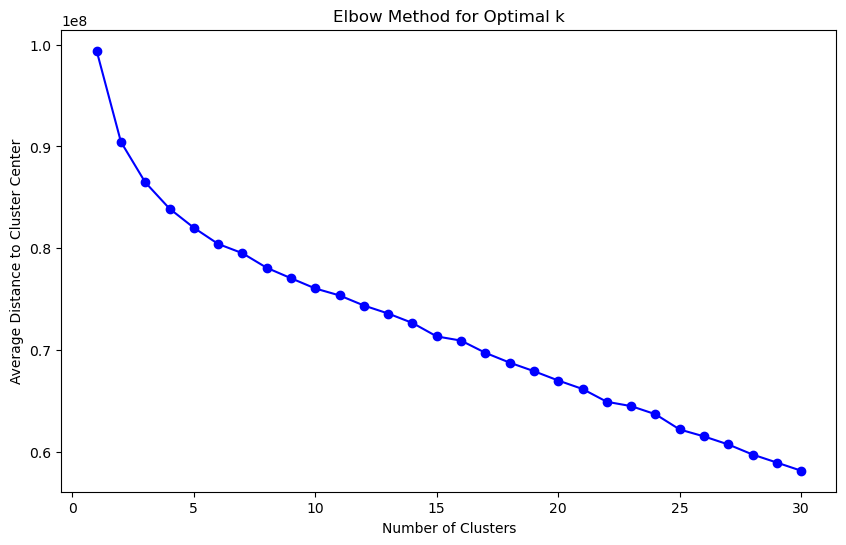

In [43]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), avg_distances, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance to Cluster Center')
plt.title('Elbow Method for Optimal k')
plt.show()


In [44]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

optimal_clusters = 20

# Apply k-means with the optimal number of clusters
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = final_kmeans.fit_predict(pca_df)

pca_df['Cluster'] = cluster_labels

/home/asakhel/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Discussion 3.1: Apply Clustering to General Population

I decided to check clusters from 1 to 30 after the clustering was done looking at the plot chart every new cluster added gave out a small improvement but the third biggest improvement was going from 19 to 20 and it has a 0.68 average distance which is the fine distance I can't go an even bigger number of cluster or the performance will be bad, with that I have decided the perfect number of luster 20.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [45]:
# Load in the customer demographics data.
customers = pd.read_csv("./Udacity_CUSTOMERS_Subset.csv", delimiter=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [46]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_cleaned = clean_data(customers)

print(customers_cleaned.isna().sum().sum())

imputed_data = imputer.transform(customers_cleaned)
customers_cleaned = pd.DataFrame(imputed_data, columns=customers_cleaned.columns)

print(customers_cleaned.isna().sum().sum())

/home/asakhel/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Series([], dtype: float64)
2243448
0


In [47]:
customers_scaled = scaler.transform(customers_cleaned)
customers_pca = pca_final.transform(customers_scaled)

customers_pca_df = pd.DataFrame(customers_pca, columns=[f'PC{i+1}' for i in range(pca_final.n_components_)])
customer_clusters = final_kmeans.predict(customers_pca_df)

# Add cluster labels to the customer PCA dataframe
customers_pca_df['Cluster'] = customer_clusters

/home/asakhel/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

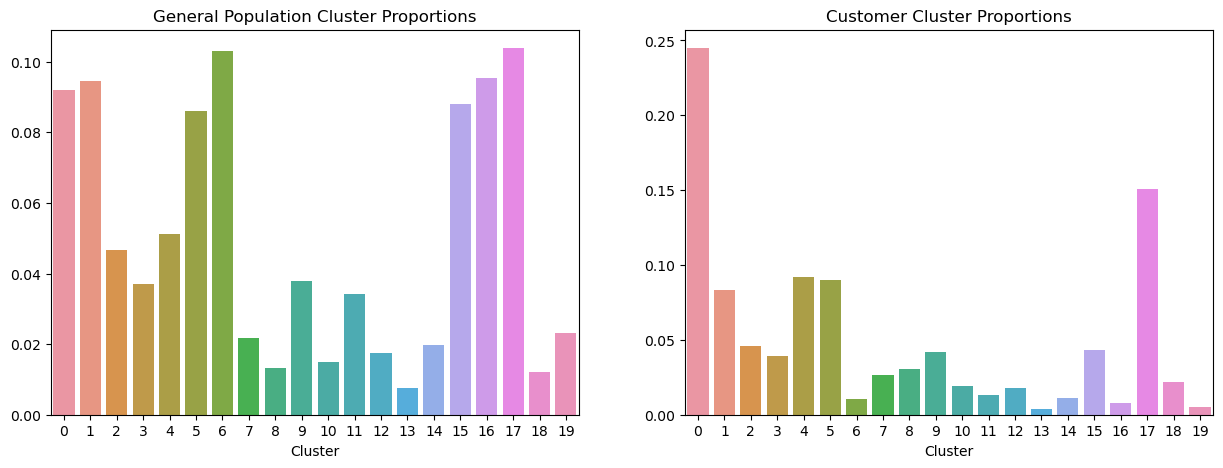

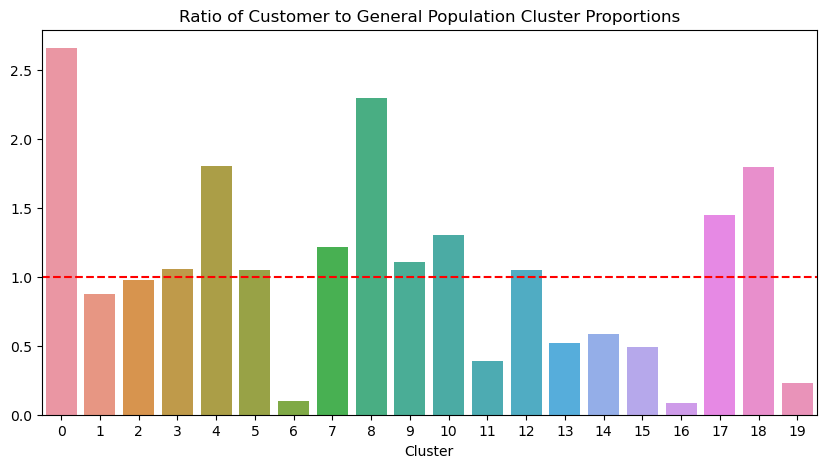

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute proportions
general_props = pca_df['Cluster'].value_counts(normalize=True)
customer_props = customers_pca_df['Cluster'].value_counts(normalize=True)

# Visualize individual dataset proportions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x=general_props.index, y=general_props.values, ax=ax1)
ax1.set_title('General Population Cluster Proportions')
sns.barplot(x=customer_props.index, y=customer_props.values, ax=ax2)
ax2.set_title('Customer Cluster Proportions')

# Visualize ratio of customer to general population proportions
ratio = customer_props / general_props
plt.figure(figsize=(10, 5))
sns.barplot(x=ratio.index, y=ratio.values)
plt.title('Ratio of Customer to General Population Cluster Proportions')
plt.axhline(y=1, color='r', linestyle='--')
plt.show()


In [49]:
centroid = final_kmeans.cluster_centers_[8]

centroid_2d = centroid.reshape(1, -1)

original_centroid = scaler.inverse_transform(pca_final.inverse_transform(centroid_2d))

centroid_df = pd.DataFrame(original_centroid, columns=scaled_geneal_population_df.columns)

# Display top features
print("Top features that are overrepresented in cluster: 8")
print(centroid_df.iloc[0].sort_values(ascending=False).head(10))

# Display bottom features
print("\nBottom features that are underrepresented in cluster: 8")
print(centroid_df.iloc[0].sort_values(ascending=True).head(10))


Top features that are overrepresented in cluster: 8
MIN_GEBAEUDEJAHR       1993.483870
KBA13_ANZAHL_PKW        723.906587
LP_LEBENSPHASE_FEIN      23.809795
LP_STATUS_FEIN            8.707404
WOHNDAUER_2008            8.032863
GFK_URLAUBERTYP           7.092735
LP_LEBENSPHASE_GROB       6.914818
LP_FAMILIE_FEIN           5.285832
ORTSGR_KLS9               4.931975
SEMIO_LUST                4.662383
Name: 0, dtype: float64

Bottom features that are underrepresented in cluster: 8
ANZ_HAUSHALTE_AKTIV                            -1.905760
Wealth_Level_Prosperous                        -0.100210
ANZ_HH_TITEL                                   -0.082295
KBA05_ANTG4                                    -0.067028
CAMEO_DEU_2015_2D                              -0.050752
CAMEO_DEU_2015_7A                              -0.042315
Life_Stage_Older Families & Mature Couples     -0.041667
CAMEO_DEU_2015_3A                              -0.039752
Life_Stage_Families With School Age Children   -0.035804
CAME

In [50]:
underrepresented_cluster = 6

# Get the centroid of the underrepresented cluster
centroid = final_kmeans.cluster_centers_[underrepresented_cluster]

# Reshape the centroid to be 2D
centroid_2d = centroid.reshape(1, -1)

# Transform centroid back to original feature space
original_centroid = scaler.inverse_transform(pca_final.inverse_transform(centroid_2d))

# Create a DataFrame of the original centroid
centroid_df = pd.DataFrame(original_centroid, columns=scaled_geneal_population_df.columns)

# Display top features
print(f"Top features that are overrepresented in cluster: 6")
print(centroid_df.iloc[0].sort_values(ascending=False).head(10))

# Display bottom features
print(f"\nBottom features that are underrepresented in cluster: 6")
print(centroid_df.iloc[0].sort_values(ascending=True).head(10))


Top features that are overrepresented in cluster: 6
MIN_GEBAEUDEJAHR       1993.105996
KBA13_ANZAHL_PKW        682.969228
LP_LEBENSPHASE_FEIN      13.317349
GFK_URLAUBERTYP           8.377950
WOHNDAUER_2008            7.174927
ANZ_HAUSHALTE_AKTIV       6.207675
SEMIO_REL                 5.862479
SEMIO_PFLICHT             5.829906
SEMIO_KULT                5.412346
SEMIO_TRADV               5.317568
Name: 0, dtype: float64

Bottom features that are underrepresented in cluster: 6
CAMEO_DEU_2015_2B   -0.000969
CAMEO_DEU_2015_4A   -0.000781
CAMEO_DEU_2015_9E   -0.000729
CAMEO_DEU_2015_2C    0.000043
CAMEO_DEU_2015_1A    0.000252
CAMEO_DEU_2015_6A    0.000387
CAMEO_DEU_2015_8D    0.000756
ANZ_TITEL            0.000915
CAMEO_DEU_2015_9A    0.001079
CAMEO_DEU_2015_1C    0.001234
Name: 0, dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data

Looking at the top features in cluster number 8 the first 1 is about the year that was building build the second one talks about the number of cars and the third one talks about life stages, so what we can get from these functions is that this cluster mail center around the life stage of a person if he is married single, how long he has been living on this property and the car numbers could show us that the more he advanced in his life stage the more cars would he have.

Looking at the bottom features in cluster number 3, the last one is about whether they were Noble Jogger, the second last is about being Family Starter the third one talks about a life stageSocking Away aka he is saving as much money, so we could say this cluster don't respect people who aren't in their early family lifestyle.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.